# Data Preprocessing Notebook

# 1.0 Importing Required Packages

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# 2.0 Reading and Preprocessing the Data

In [2]:
df = pd.read_csv("../METABRIC_RNA_Mutation.csv")
df.head()

C:\Users\as\AppData\Local\Temp\ipykernel_17688\3338052983.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


## 2.1 Drop Irrelevant Columns
Dropping `patient_id` as it didn't add any relvant information for modeling, as well as `cancer_type` as it almost uniform except only one instance with **Breast Sarcoma** as identified in the Exploratory Data Analysis (EDA) Notebook

In [3]:
df.drop(columns=["patient_id", "cancer_type"], inplace=True)

In [4]:
df.head()

,age_at_diagnosis,type_of_breast_surgery,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,75.65,MASTECTOMY,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0
1,43.19,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0
2,48.87,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,2.0,...,0,0,0,0,0,0,0,0,0,0
3,47.68,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,2.0,...,0,0,0,0,0,0,0,0,0,0
4,76.97,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0


## 2.2 Handle Missing Values

In [5]:
df.isnull().sum()

age_at_diagnosis           0
type_of_breast_surgery    22
cancer_type_detailed      15
cellularity               54
chemotherapy               0
                          ..
hras_mut                   0
prps2_mut                  0
smarcb1_mut                0
stmn2_mut                  0
siah1_mut                  0
Length: 691, dtype: int64

### 2.2.1 Handle Categorical Columns with the Mode

In [6]:
categorical_cols = [
    "type_of_breast_surgery",
    "cancer_type_detailed",
    "cellularity",
    "er_status_measured_by_ihc",
    "tumor_other_histologic_subtype",
    "oncotree_code",
    "primary_tumor_laterality",
    "3-gene_classifier_subtype",
    "death_from_cancer"
]

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

### 2.2.2 Handle Numerical Columns with the Median

In [7]:
numeric_cols = [
    "neoplasm_histologic_grade",
    "lymph_nodes_examined_positive",
    "mutation_count",
    "tumor_size",
    "overall_survival_months",
]

for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

### 2.2.3 Handle `tumor_stage` Column using `KNNImputer`

In [8]:
# Impute tumor stage with KNN
tumor_stage = df[["tumor_stage"]]
imputer = KNNImputer(n_neighbors=3)
tumor_stage_imputed = imputer.fit_transform(tumor_stage)
tumor_stage_imputed = pd.DataFrame(tumor_stage_imputed, columns=["tumor_stage"])
df["tumor_stage"] = tumor_stage_imputed

### 2.2.4 Ensure that Data Don't Contain Missing Values 

In [9]:
df.isnull().sum().sum()

0

## 2.3 Splitting the Data to 3 Groups

In [10]:
clinical_data = df.iloc[:, :29]
m_rna_data = df.iloc[:, 29:-173]
mutation_data = df.iloc[:, -173:]

In [11]:
clinical_data.head()

,age_at_diagnosis,type_of_breast_surgery,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,75.65,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,0,claudin-low,1.0,Positve,Positive,3.0,...,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living
1,43.19,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,3.0,...,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living
2,48.87,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,2.0,...,4.030,IDC,163.700000,0,Positive,0,ER+/HER2- Low Prolif,15.0,2.0,Died of Disease
3,47.68,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,2.0,...,4.050,MDLC,164.933333,1,Positive,1,ER+/HER2- Low Prolif,25.0,2.0,Living
4,76.97,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,3.0,...,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [12]:
m_rna_data.head()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,...,-1.1877,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,...,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920
2,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,...,-0.5381,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655
3,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,...,-0.5630,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,...,-0.5845,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223


In [13]:
mutation_data.head()

,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,H178P,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,H1047R,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,E542K,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,S241F,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2.4 Preprocessing Each Group

### 2.4.1 Preprocessing Clinical Data

In [14]:
clinical_data.head()

,age_at_diagnosis,type_of_breast_surgery,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,75.65,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,0,claudin-low,1.0,Positve,Positive,3.0,...,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living
1,43.19,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,3.0,...,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living
2,48.87,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,2.0,...,4.030,IDC,163.700000,0,Positive,0,ER+/HER2- Low Prolif,15.0,2.0,Died of Disease
3,47.68,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,2.0,...,4.050,MDLC,164.933333,1,Positive,1,ER+/HER2- Low Prolif,25.0,2.0,Living
4,76.97,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,3.0,...,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [15]:
clinical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age_at_diagnosis                1904 non-null   float64
 1   type_of_breast_surgery          1904 non-null   object 
 2   cancer_type_detailed            1904 non-null   object 
 3   cellularity                     1904 non-null   object 
 4   chemotherapy                    1904 non-null   int64  
 5   pam50_+_claudin-low_subtype     1904 non-null   object 
 6   cohort                          1904 non-null   float64
 7   er_status_measured_by_ihc       1904 non-null   object 
 8   er_status                       1904 non-null   object 
 9   neoplasm_histologic_grade       1904 non-null   float64
 10  her2_status_measured_by_snp6    1904 non-null   object 
 11  her2_status                     1904 non-null   object 
 12  tumor_other_histologic_subtype  19

#### 2.4.1.1 Encoding Categorical Features

In [16]:
print(f"categorical features: \n{clinical_data.select_dtypes(include='object').columns.to_list()}")

categorical features: 
['type_of_breast_surgery', 'cancer_type_detailed', 'cellularity', 'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'oncotree_code', 'pr_status', '3-gene_classifier_subtype', 'death_from_cancer']


##### 2.4.1.1.1 Encoding Ordinal Features (`cellularity`)

In [17]:
clinical_data["cellularity"] = clinical_data["cellularity"].map({"Low": 0, "Moderate": 1, "High": 2})

##### 2.4.1.1.2 Encoding the Target Variable `death_from_cancer`

In [18]:
le = LabelEncoder()
clinical_data["death_from_cancer"] = le.fit_transform(clinical_data["death_from_cancer"])

##### 2.4.1.1.3 Encoding Nominal Features

In [19]:
clinical_data_encoded = pd.get_dummies(clinical_data)

##### 2.4.1.1.4 Check the Data Types for each Feature

In [20]:
clinical_data_encoded.dtypes.value_counts()

uint8      60
float64     9
int64       5
int32       1
dtype: int64

As we can see, the `clincial_data_encoded` contains only numerical data types

In [21]:
clinical_data_encoded.head()

,age_at_diagnosis,cellularity,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,...,oncotree_code_ILC,oncotree_code_IMMC,oncotree_code_MBC,oncotree_code_MDLC,pr_status_Negative,pr_status_Positive,3-gene_classifier_subtype_ER+/HER2- High Prolif,3-gene_classifier_subtype_ER+/HER2- Low Prolif,3-gene_classifier_subtype_ER-/HER2-,3-gene_classifier_subtype_HER2+
0,75.65,2,0,1.0,3.0,1,10.0,5.0,6.044,140.500000,...,0,0,0,0,1,0,0,0,1,0
1,43.19,2,0,1.0,3.0,1,0.0,2.0,4.020,84.633333,...,0,0,0,0,0,1,1,0,0,0
2,48.87,2,1,1.0,2.0,1,1.0,2.0,4.030,163.700000,...,0,0,0,0,0,1,0,1,0,0
3,47.68,1,1,1.0,2.0,1,3.0,1.0,4.050,164.933333,...,0,0,0,1,0,1,0,1,0,0
4,76.97,2,1,1.0,3.0,1,8.0,2.0,6.080,41.366667,...,0,0,0,1,0,1,1,0,0,0


#### 2.4.1.2 Remove Correlted Features

##### 2.4.1.2.1 Displaying the Correlation Matrix

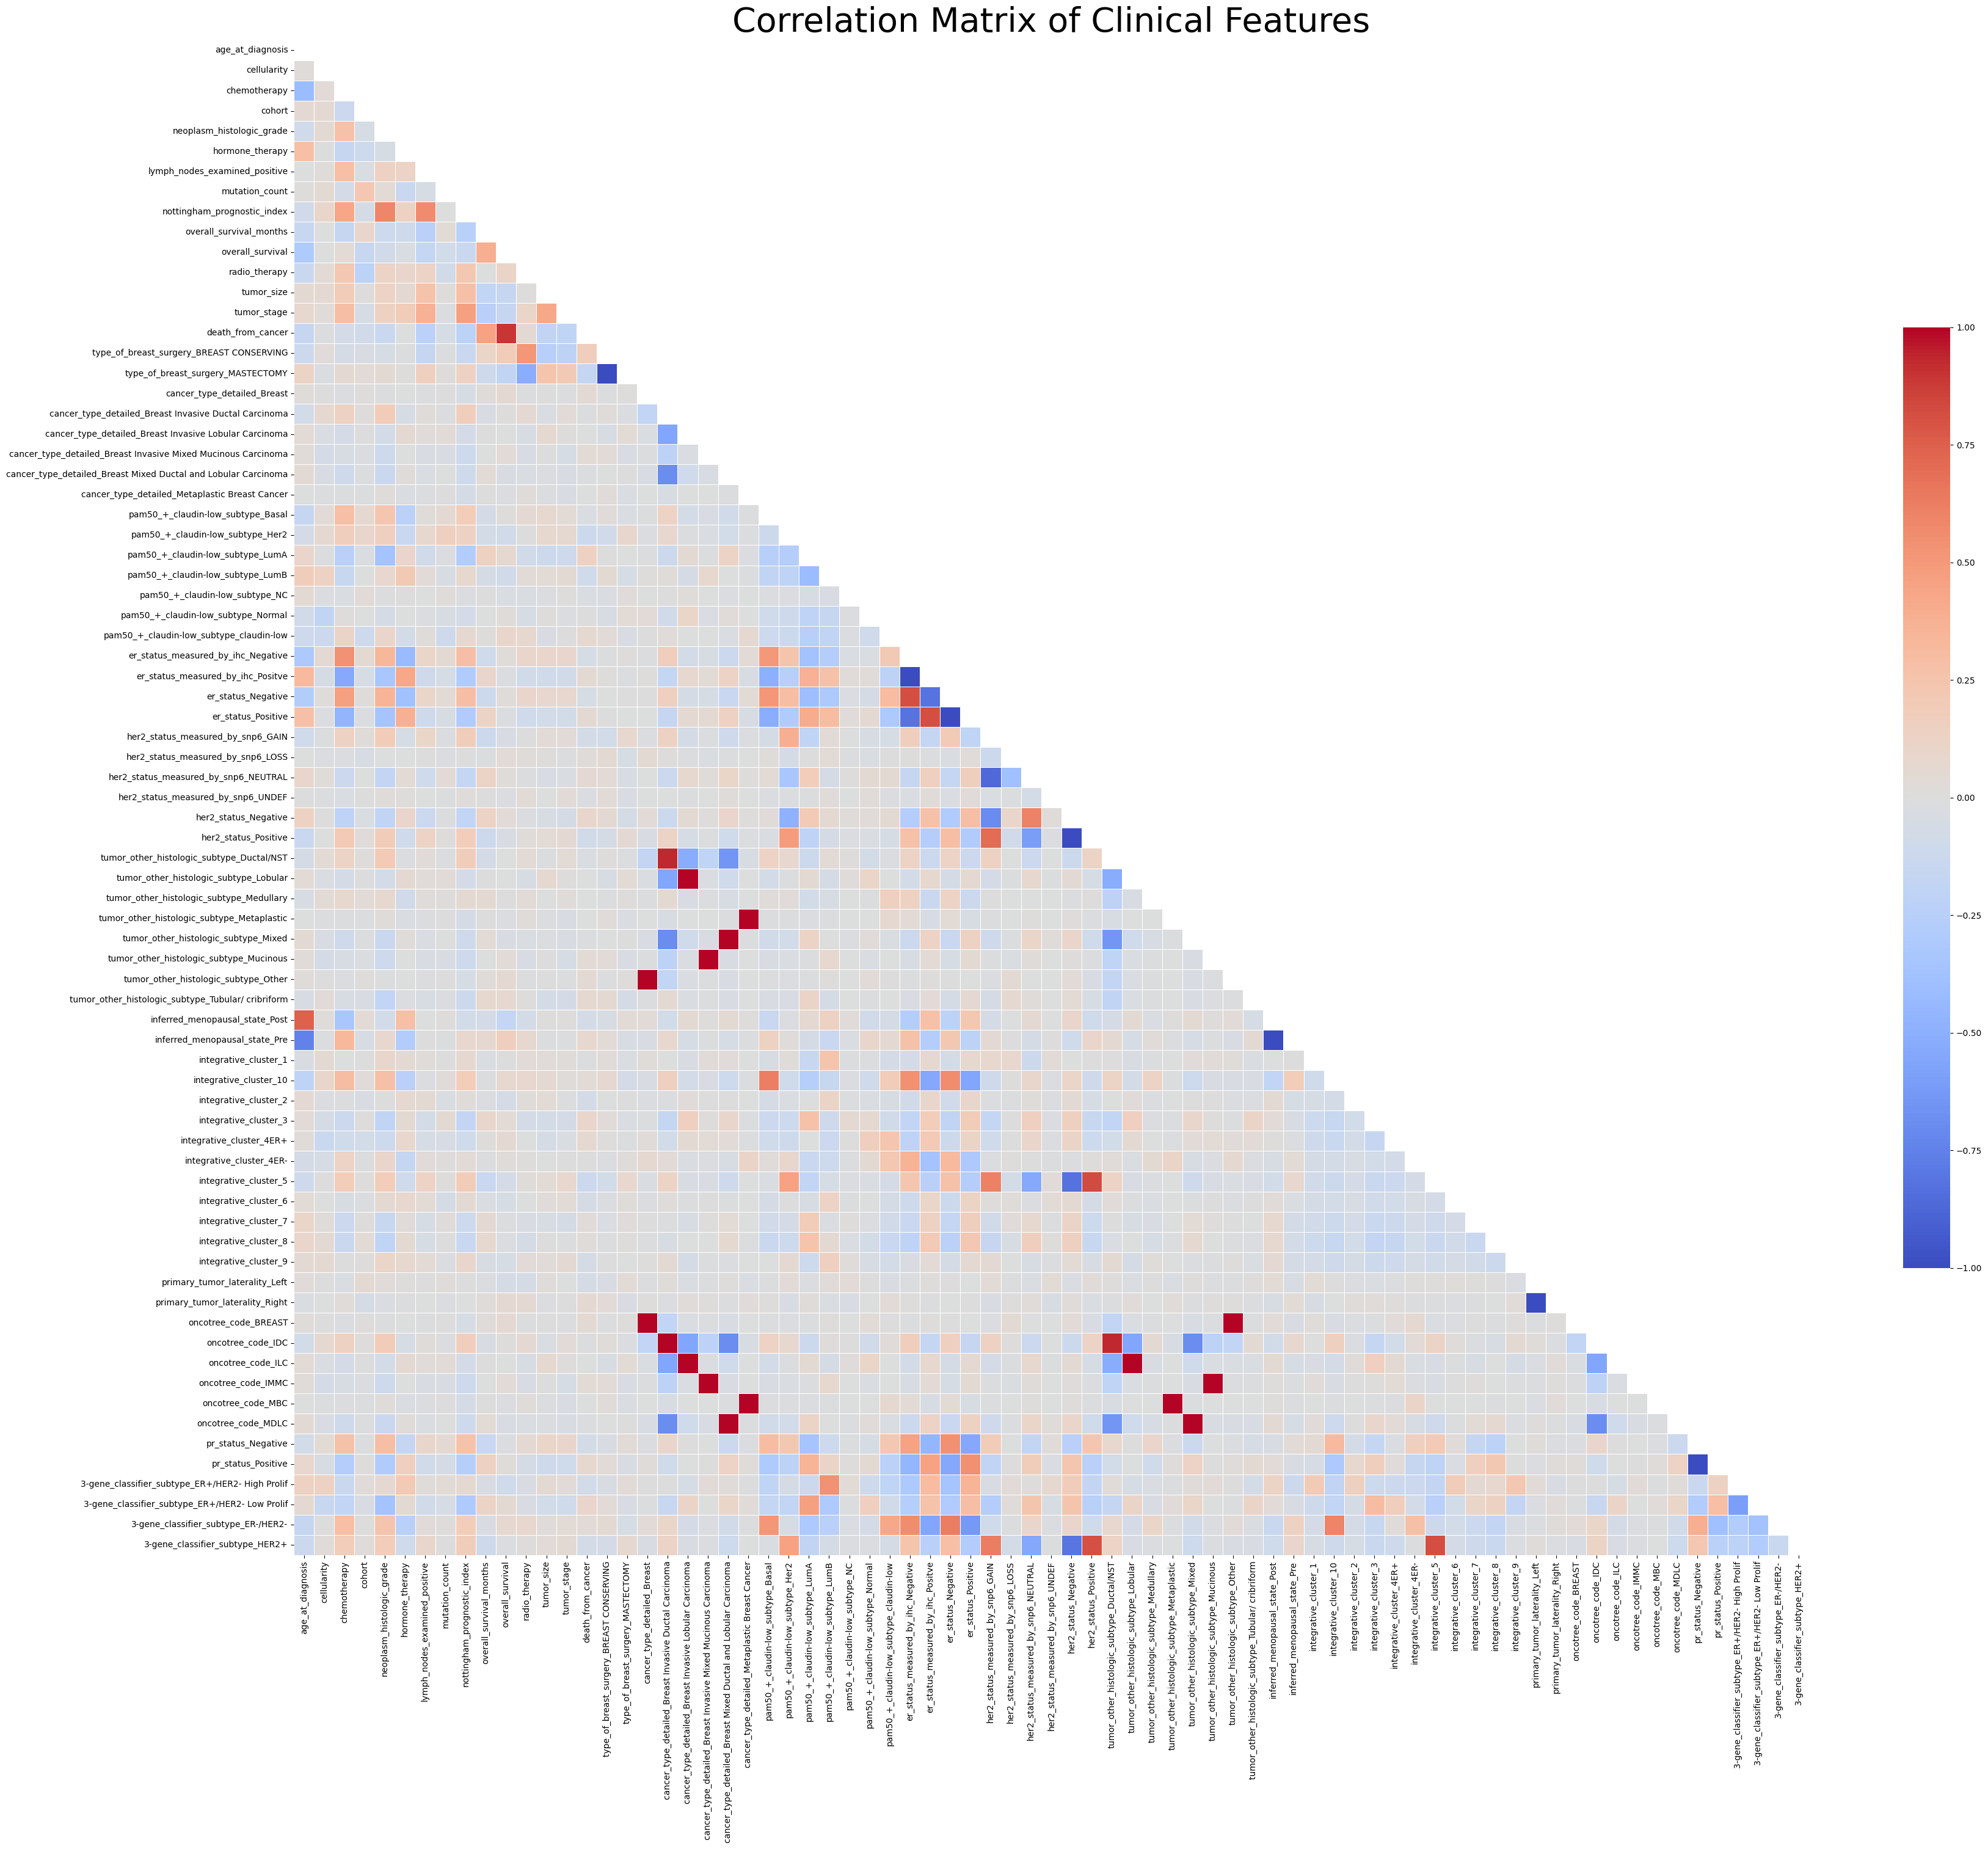

In [22]:
corr_matrix = clinical_data_encoded.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(40, 40))

sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
plt.title("Correlation Matrix of Clinical Features", fontsize=40, pad=10)
plt.show()

##### 2.4.1.2.2 Identifying the Columns to Drop

In [23]:
threshold = 0.9

# Apply the mask to the correlation matrix
tri_upper = corr_matrix.mask(mask)

# Identify columns to drop
to_drop = [column for column in tri_upper.columns if any(tri_upper[column].abs() > threshold)]

print(f"Columns to drop:\n{to_drop}")

Columns to drop:
['type_of_breast_surgery_BREAST CONSERVING', 'cancer_type_detailed_Breast', 'cancer_type_detailed_Breast Invasive Ductal Carcinoma', 'cancer_type_detailed_Breast Invasive Lobular Carcinoma', 'cancer_type_detailed_Breast Invasive Mixed Mucinous Carcinoma', 'cancer_type_detailed_Breast Mixed Ductal and Lobular Carcinoma', 'cancer_type_detailed_Metaplastic Breast Cancer', 'er_status_measured_by_ihc_Negative', 'er_status_Negative', 'her2_status_Negative', 'tumor_other_histologic_subtype_Ductal/NST', 'tumor_other_histologic_subtype_Lobular', 'tumor_other_histologic_subtype_Metaplastic', 'tumor_other_histologic_subtype_Mixed', 'tumor_other_histologic_subtype_Mucinous', 'tumor_other_histologic_subtype_Other', 'inferred_menopausal_state_Post', 'primary_tumor_laterality_Left', 'pr_status_Negative']


##### 2.4.1.2.3 Drop Correlated Columns

In [24]:
clinical_data_encoded.drop(columns=to_drop, inplace=True)
clinical_data_encoded.head()

,age_at_diagnosis,cellularity,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,...,oncotree_code_IDC,oncotree_code_ILC,oncotree_code_IMMC,oncotree_code_MBC,oncotree_code_MDLC,pr_status_Positive,3-gene_classifier_subtype_ER+/HER2- High Prolif,3-gene_classifier_subtype_ER+/HER2- Low Prolif,3-gene_classifier_subtype_ER-/HER2-,3-gene_classifier_subtype_HER2+
0,75.65,2,0,1.0,3.0,1,10.0,5.0,6.044,140.500000,...,1,0,0,0,0,0,0,0,1,0
1,43.19,2,0,1.0,3.0,1,0.0,2.0,4.020,84.633333,...,1,0,0,0,0,1,1,0,0,0
2,48.87,2,1,1.0,2.0,1,1.0,2.0,4.030,163.700000,...,1,0,0,0,0,1,0,1,0,0
3,47.68,1,1,1.0,2.0,1,3.0,1.0,4.050,164.933333,...,0,0,0,0,1,1,0,1,0,0
4,76.97,2,1,1.0,3.0,1,8.0,2.0,6.080,41.366667,...,0,0,0,0,1,1,1,0,0,0


##### 2.4.1.2.4 Displaying the Correlation Matrix after Removing Correlated Columns

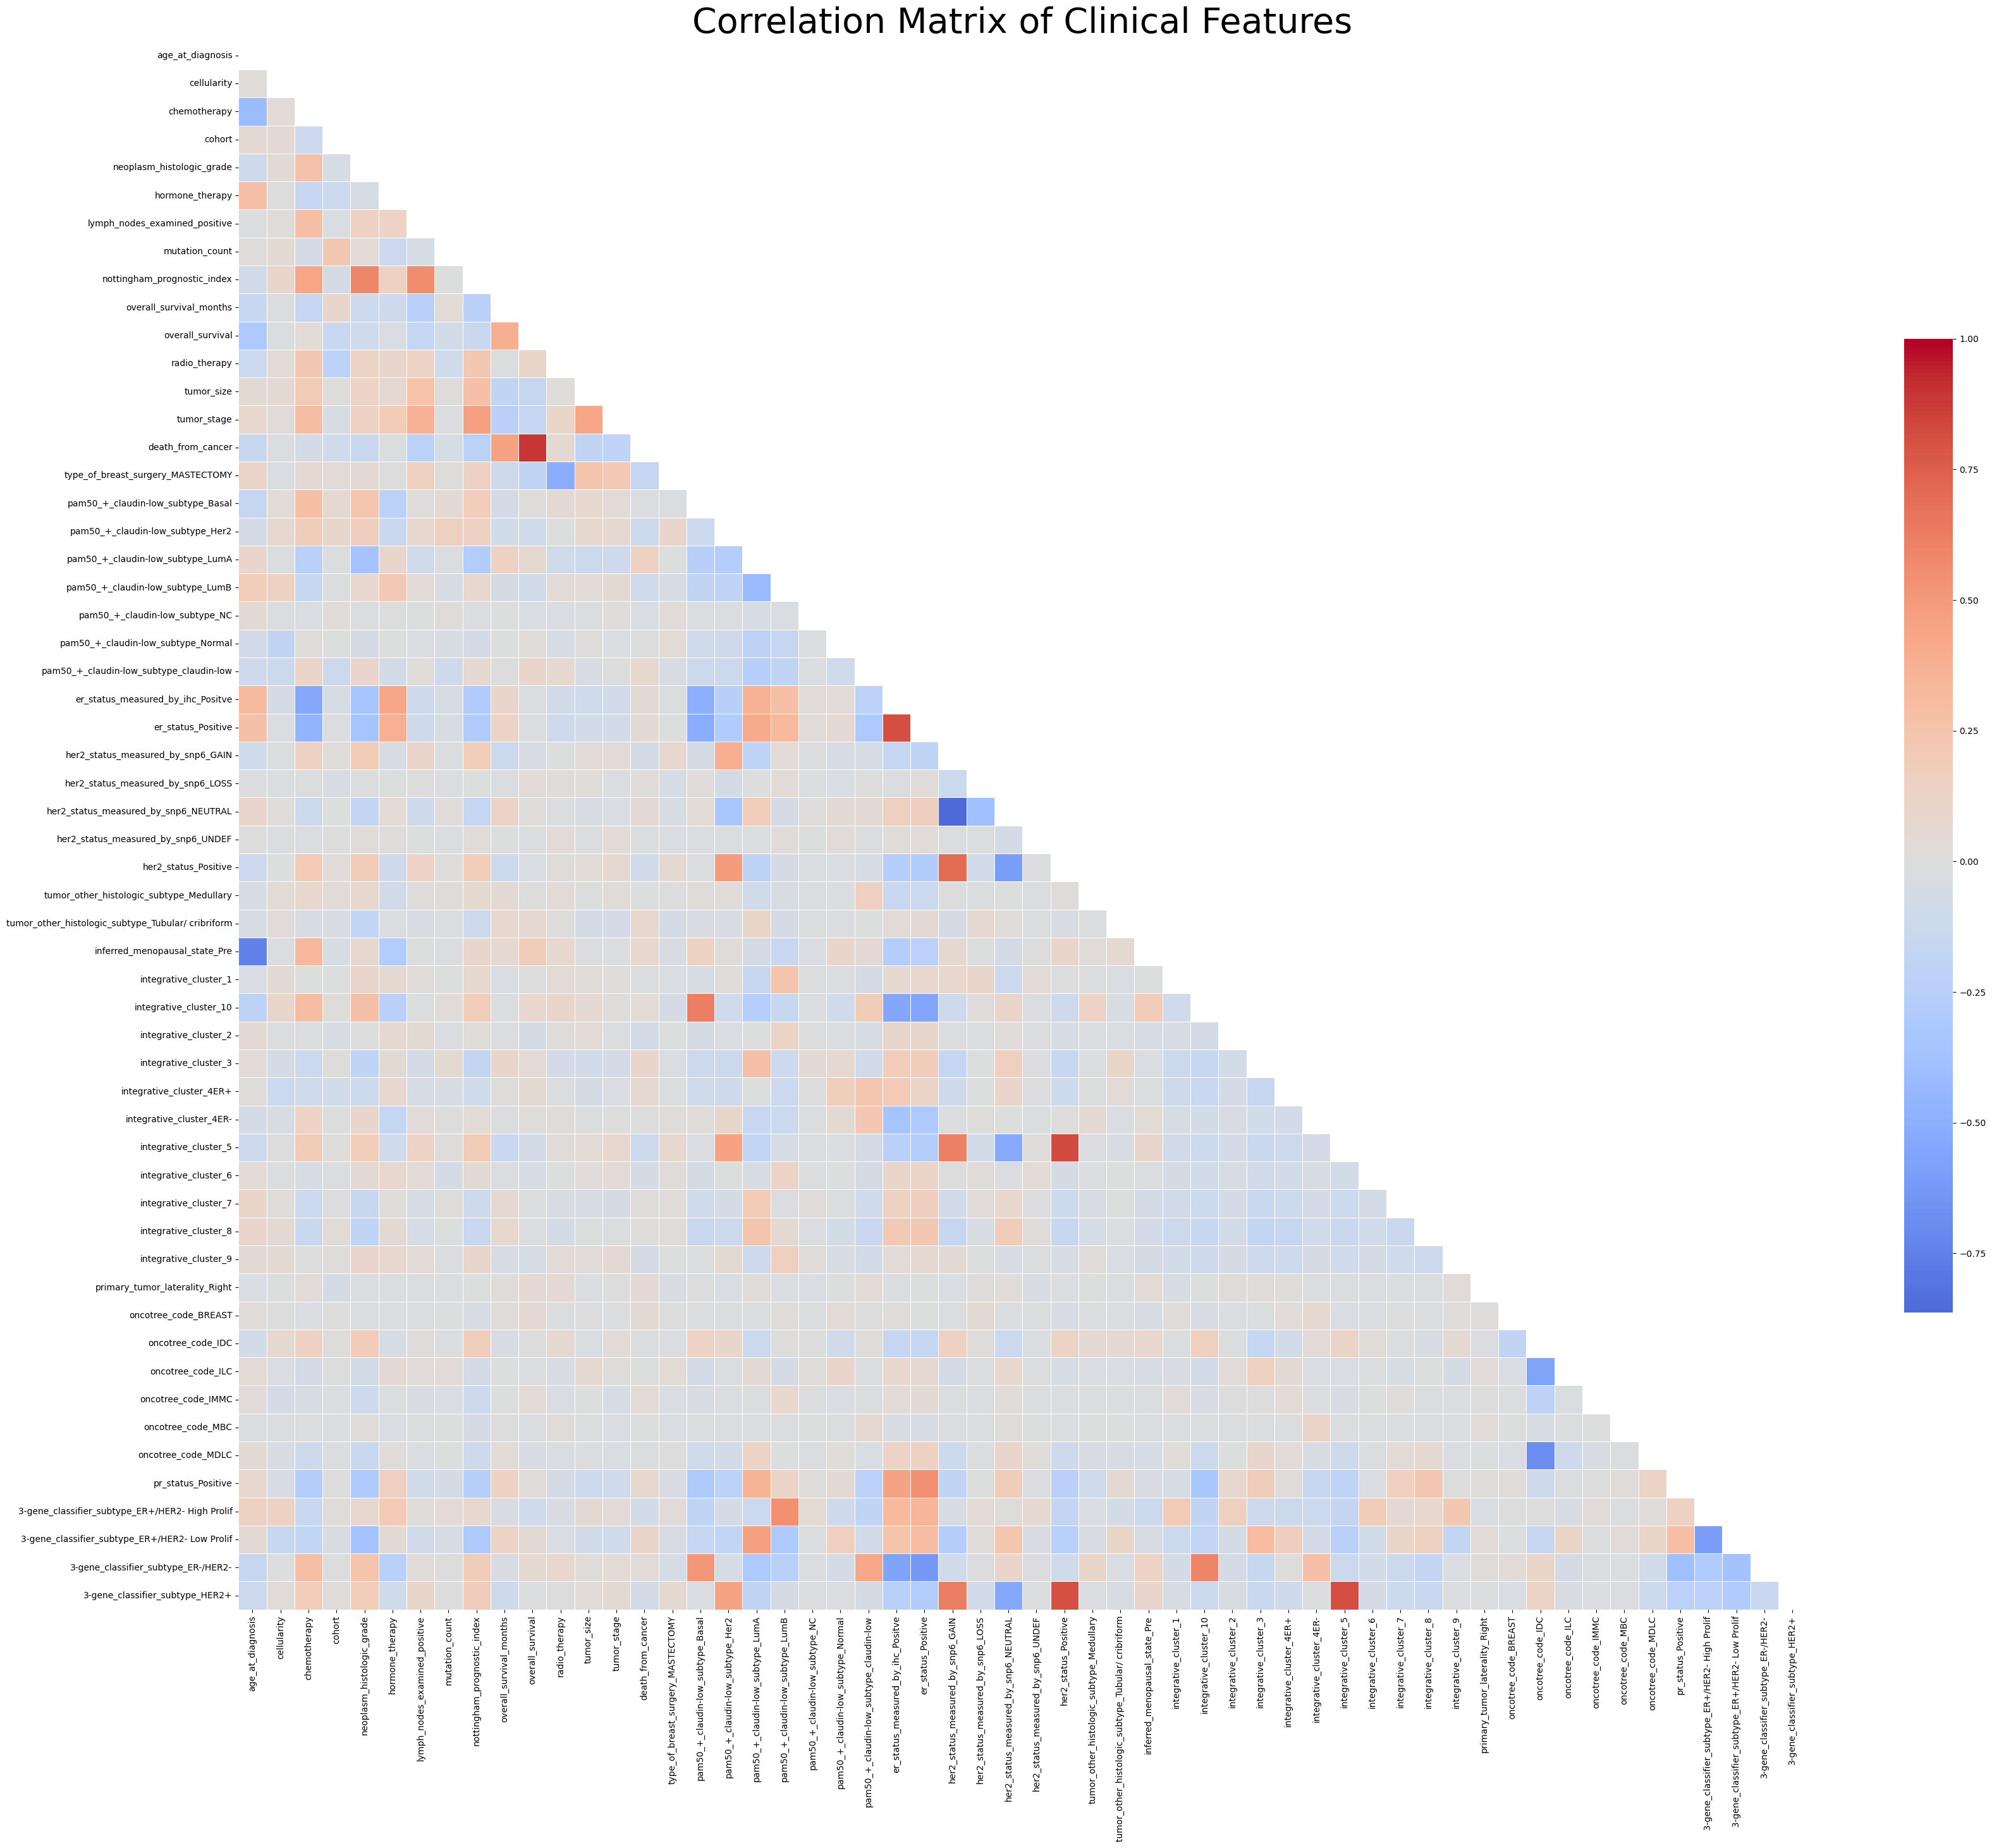

In [25]:
corr_matrix = clinical_data_encoded.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(40, 40))

sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
plt.title("Correlation Matrix of Clinical Features", fontsize=40, pad=10)
plt.show()

### 2.4.2 Preprocessing Mutation Data

In [26]:
mutation_data.head()

,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,H178P,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,H1047R,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,E542K,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,S241F,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
mutation_data.dtypes.value_counts()

object    173
dtype: int64

#### 2.4.2.1 Binary Encoding for Each Mutation

In [28]:
mutated_columns = {}

# Binary encoding for the presence of any mutation
for col in mutation_data.columns:
    mutated_columns[col] = mutation_data[col].apply(lambda x: 0 if x == "0" else 1)

mutation_data = pd.DataFrame(mutated_columns)
mutation_data.head()

,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1


#### 2.4.2.2 Check the Data Type of Each Feature

In [29]:
mutation_data.dtypes.value_counts()

int64    173
dtype: int64

As we can see, `mutation_data` contains only numerical data types.

### 2.4.3 Combining all of the Data to a Single `DataFrame`

In [30]:
df_full = pd.concat([clinical_data_encoded, m_rna_data, mutation_data], axis=1)
df_full.head()

,age_at_diagnosis,cellularity,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,75.65,2,0,1.0,3.0,1,10.0,5.0,6.044,140.500000,...,0,0,0,0,0,1,0,1,0,1
1,43.19,2,0,1.0,3.0,1,0.0,2.0,4.020,84.633333,...,0,0,0,0,0,1,0,1,0,1
2,48.87,2,1,1.0,2.0,1,1.0,2.0,4.030,163.700000,...,0,0,0,0,0,1,0,1,0,1
3,47.68,1,1,1.0,2.0,1,3.0,1.0,4.050,164.933333,...,0,0,0,0,0,1,0,1,0,1
4,76.97,2,1,1.0,3.0,1,8.0,2.0,6.080,41.366667,...,0,0,0,0,0,1,0,1,0,1


## 2.5 Nomralizing Columns Names
Replacing any special characters with `_` letter for easily accessing the column names

In [31]:
df_full.columns = [re.sub(r"[!@#$%^&*(){}\[\];:,./<>?\\|`~\=_\']", "_", col) for col in df_full.columns]

In [32]:
df_full.head()

,age_at_diagnosis,cellularity,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,75.65,2,0,1.0,3.0,1,10.0,5.0,6.044,140.500000,...,0,0,0,0,0,1,0,1,0,1
1,43.19,2,0,1.0,3.0,1,0.0,2.0,4.020,84.633333,...,0,0,0,0,0,1,0,1,0,1
2,48.87,2,1,1.0,2.0,1,1.0,2.0,4.030,163.700000,...,0,0,0,0,0,1,0,1,0,1
3,47.68,1,1,1.0,2.0,1,3.0,1.0,4.050,164.933333,...,0,0,0,0,0,1,0,1,0,1
4,76.97,2,1,1.0,3.0,1,8.0,2.0,6.080,41.366667,...,0,0,0,0,0,1,0,1,0,1


## 2.6 Saving the Preprocessed Dataset

In [34]:
df_full.to_csv("df_preprocessed.csv", index=False)